<a href="https://colab.research.google.com/github/chain28/UNDSP-D-25-00030/blob/main/NSGA2_Scene6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#README

This notebook contains sample Python code designed to optimize operational parameters of the shield machine, such as face pressure, thrust force, grout pressure, and grout filling percentage, by evaluating a fitness metric that aims to reduce ground surface settlement while increasing the average penetration rate.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model

import matplotlib.pyplot as plt

!pip install deap
from deap import base, creator, tools, algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00


In [ ]:
SCENE_NO = 6

# Settlement and penetration rate have a same set of max-min value
MAX_value = [44.62, 59.2459666666667, 206.01, 13057.11, 0.5, 470.88, 335.333333333333, 24.8126366133333, 4.33686911]
MIN_value = [3.33, 3.11027, 18.3333333333333, 5794.44, -1.28666666666667, 58.86, 70.6666666666667, 14.51313089, -5.96263661466667]

# Boundaries range equal to +/- 1.25 SD <<< From penetration rate to avoid the redundant
BOUND_UPPER = [0.906627970201264, 0.852962216205773, 0.494281970041358, 0.322248550410388]
BOUND_LOWER = [0.196423739133436, 0.237969325993184, 0.219940370636207, 0.0949851801809877]

In [ ]:
start_time = time.time()

df_optimized = pd.DataFrame()
itr_count = 0

def evaluate(individual):
  global df_scene, df_optimized, itr_count

  # Iteration counter
  itr_count += 1
  if itr_count % 100 == 0:
    print(f"Iteration: {itr_count}")

  # Check individual boundaries
  if (individual[0] < BOUND_LOWER[0] or individual[0] > BOUND_UPPER[0] or # Face pressure
    individual[1] < BOUND_LOWER[1] or individual[1] > BOUND_UPPER[1] or   # Thrust force
    individual[2] < BOUND_LOWER[2] or individual[2] > BOUND_UPPER[2] or   # Grout pressure
    individual[3] < BOUND_LOWER[3] or individual[3] > BOUND_UPPER[3]      # Percent grout filling
    ):
    obj1 = 50 #The model will inform the heave as high settlement and evaluate the individual as bad result
    obj2 = 0
    return obj1, obj2
  else:
    # Change individual to DataFrame and reshape to 11 rows and 4 columns
    df_idv = pd.DataFrame([individual], columns=["Face pressure", "Thrust force", "Grout pressure", "Percent grout filling"])
    df_individual = pd.concat([df_idv]*11, ignore_index=True)

    # Combine individual and scenario into one DataFrame for penetration rate
    df_optim_pen = pd.concat([df_individual.iloc[:,0:2],df_scene.iloc[:,2],df_individual.iloc[:,2:],df_scene.iloc[:,5:]],axis=1)


    # Predict penetration rate
    y_pen_list = list()
    for a in range(0,11):
      X_pen  = df_optim_pen.iloc[a,:].values
      Xt_pen = X_pen.reshape((1,1,X_pen.shape[0]))
      y_pen_list.append(model_pen.predict(Xt_pen, verbose=0).squeeze())

    df_y_pen_norm = pd.DataFrame(y_pen_list)
    df_y_pen      = (df_y_pen_norm*(MAX_value[1]-MIN_value[1]))+MIN_value[1]
    df_avg_y_pen  = df_y_pen.mean(axis=0)
    obj2          = df_avg_y_pen.iloc[0]

    # Combine individual and scenario into one DataFrame for settlement
    df_optim_set = pd.concat([df_y_pen_norm, df_optim_pen],axis=1)

    # Predict settlement
    X_set = df_optim_set.values
    Xt_set = X_set.reshape((1,11,X_set.shape[1]))
    y_set_norm = model_set.predict(Xt_set, verbose=0).squeeze()
    obj1 = (y_set_norm*(MAX_value[0]-MIN_value[0]))+MIN_value[0]

    optimized_data = {
      "Settlement (mm)": [obj1],
      "Avg. penetration rate (mm/min)": [obj2],
      "Face pressure (kPa)": [(df_individual.iloc[0,0]*(MAX_value[2]-MIN_value[2]))+MIN_value[2]],
      "Thrust force (kN)": [(df_individual.iloc[0,1]*(MAX_value[3]-MIN_value[3]))+MIN_value[3]],
      "Grout pressure (kPa)": [(df_individual.iloc[0,2]*(MAX_value[5]-MIN_value[5]))+MIN_value[5]],
      "Percent grout filling (%)": [(df_individual.iloc[0,3]*(MAX_value[6]-MIN_value[6]))+MIN_value[6]]
    }

    df_optimized_new = pd.DataFrame(optimized_data)
    df_optimized     = pd.concat([df_optimized, df_optimized_new], axis=0)
    return obj1, obj2

# Boundaries checker
def checkBounds(minimum, maximum):
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for child in offspring:
                for i in range(len(child)):
                    child[i] = max(min(child[i], maximum[i]), minimum[i])
            return offspring
        return wrapper
    return decorator

# =====[Main code]=====
model_set = load_model(f"/content/drive/MyDrive/Journal/A-02_Prediction - Model/B-01_BL - New - 25 cases/Callback_LSTM - SET - ARCH 1 Fold 2.keras")
model_pen = load_model(f"/content/drive/MyDrive/Journal/A-02_Prediction - Model/B-01_BL - New - 25 cases/Callback_LSTM - PEN - Best.keras")

df_scene_all = pd.read_excel("/content/drive/MyDrive/Journal/B-01_Optim - Dataset/BL - Optim - Scene dataset (NEW).xlsx")
df_scene = df_scene_all.iloc[(SCENE_NO*11)-11:SCENE_NO*11,2:]
df_scene = df_scene.reset_index(drop=True)

# =====[Genetic operator]=====
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0))
creator.create("individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.individual, toolbox.attr_float, n=4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.7)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.3)
toolbox.decorate("mate", checkBounds(BOUND_LOWER, BOUND_UPPER))
toolbox.decorate("mutate", checkBounds(BOUND_LOWER, BOUND_UPPER))
toolbox.register("select", tools.selNSGA2)
toolbox.register("evaluate", evaluate)

population = toolbox.population(n=300) # <<< 100 is dummy, do not forget to change to 300!!!
algorithms.eaMuPlusLambda(population, toolbox, mu=300, lambda_=300, cxpb=0.7, mutpb=0.2, ngen=50, stats=None, verbose=False) # 20 generation is dummy, do not forget to change to 50!!!

# Save a raw result

df_optim_rearranged = df_optimized.sort_values(by=["Settlement (mm)", "Avg. penetration rate (mm/min)"], ascending=[True, True])
df_optim_rearranged = df_optim_rearranged.reset_index(drop=True)

df_optim_rearranged.to_excel(f"/content/drive/MyDrive/Journal/C-01_Optim - 4 params/Raw - Scene {SCENE_NO} - DUMMY.xlsx")

finish_time = time.time()
print(f"Total time: {(finish_time-start_time):.2f} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 24 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Iteration: 1900
Iteration: 2000
Iteration: 2100
Iteration: 2200
Iteration: 2300
Iteration: 2400
Iteration: 2500
Iteration: 2600
Iteration: 2700
Iteration: 2800
Iteration: 2900
Iteration: 3000
Iteration: 3100
Iteration: 3200
Iteration: 3300
Iteration: 3400
Iteration: 3500
Iteration: 3600
Iteration: 3700
Iteration: 3800
Iteration: 3900
Iteration: 4000
Iteration: 4100
Iteration: 4200
Iteration: 4300
Iteration: 4400
Iteration: 4500
Iteration: 4600
Iteration: 4700
Iteration: 4800
Iteration: 4900
Iteration: 5000
Iteration: 5100
Iteration: 5200
Iteration: 5300
Iteration: 5400
Iteration: 5500
Iteration: 5600
Iteration: 5700
Iteration: 5800
Iteration: 5900
Iteration: 6000
Iteration: 6100
Iteration: 6200
Iteration: 6300
I

Front: 4197/13495


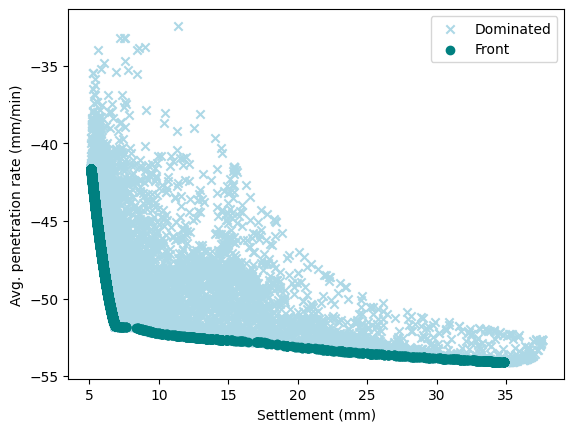

In [ ]:
def identify_pareto(scores):
  # Count the number of scores
  population_size = scores.shape[0]
  # Create a boolean array to indicate whether each point is on the Pareto front
  pareto_front = np.ones(population_size, dtype=bool)
  # Iterate through each point
  for i in range(population_size):
    # Compare point i with all other points
    for j in range(population_size):
      # Check if any other point dominates point i
      if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
        # If yes, point i is not on the Pareto front
          pareto_front[i] = 0
          break
  return pareto_front

# Collect only fitness values
df_fitness = df_optim_rearranged.copy().iloc[:,:2]
df_fitness.iloc[:,1] *= -1
fitness_value = df_fitness.values

# Identify pareto front result
pareto_front_id = identify_pareto(fitness_value)
df_optim_rearranged["Pareto front ID"] = pareto_front_id

df_front     = df_optim_rearranged[df_optim_rearranged["Pareto front ID"]]
df_dominated = df_optim_rearranged[~df_optim_rearranged["Pareto front ID"]]
print(f"Front: {df_front.shape[0]}/{df_optim_rearranged.shape[0]}")

df_front.to_excel(f"/content/drive/MyDrive/Journal/C-01_Optim - 4 params/Front - Scene {SCENE_NO} - DUMMY.xlsx")
df_dominated.to_excel(f"/content/drive/MyDrive/Journal/C-01_Optim - 4 params/DOMINATED - Scene {SCENE_NO} - DUMMY.xlsx")

plt.scatter(df_dominated.iloc[:,0], df_dominated.iloc[:,1]*-1, color="lightblue", marker="x", label="Dominated")
plt.scatter(df_front.iloc[:,0], df_front.iloc[:,1]*-1, color="teal", marker="o", label="Front")
plt.xlabel("Settlement (mm)")
plt.ylabel("Avg. penetration rate (mm/min)")
plt.legend()
plt.show()